# Analysis of Followers

In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
sns.set_theme(style="darkgrid")

First, read all the files belonging to the followers and group them by id to sum their counts

In [8]:
df = pd.concat([pd.read_csv(f, index_col=0) for f in glob.glob('./data/*_followers.csv')], ignore_index=False)
# group them by id to sum the counts
df = df.groupby(["id"]).sum()
# store the total amount of interactions
df["total"] = df["quote_count"] + df["reply_count"] + df["retweet_count"] + df["like_count"]
# make data anonymous
df = df.reset_index().drop(columns=["id"])
df

,quote_count,reply_count,retweet_count,like_count,total
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,1,1
3,0,0,0,0,0
4,0,3,0,32,35
...,...,...,...,...,...
174,0,0,0,1,1
175,0,0,0,0,0
176,0,0,0,0,0
177,0,3,0,4,7


Inspect the distributions for each interaction

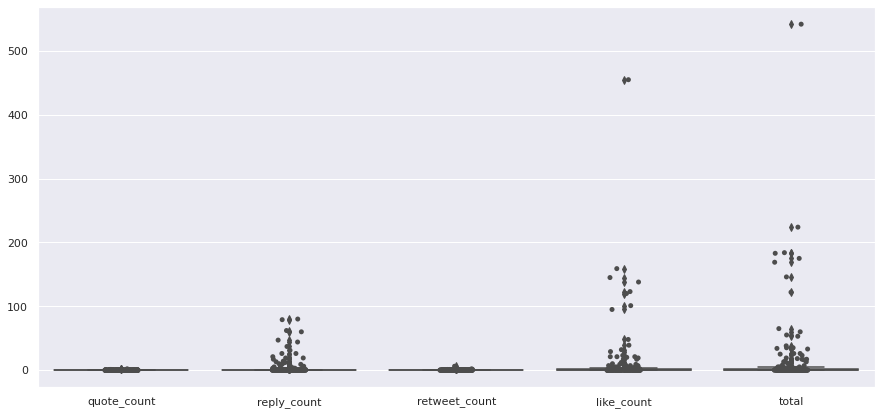

In [3]:
fig, ax = plt.subplots(figsize=(15,7))
_ = sns.boxplot(data=df, ax=ax)
_ = sns.stripplot(data=df, color=".3", ax=ax)

We are not interested in people without interactions (which are a lot) and there are outliers in the upper limit that need to be filtered.
Let's get the distribution for each filtered quantity independently.

In [4]:
def find_outliers_limit(df, col, z=1.5):
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    cut_off = iqr * z
    lower, upper = q25 - cut_off, q75 + cut_off
    return lower,upper

def get_outliers_filter(data, col):
    lower, upper = find_outliers_limit(data, col)
    return (data[col] < lower) | (data[col] > upper)

def remove_with_iqr(df, col):
    return df[ ~get_outliers_filter(df,col) ]

def remove_dummy(df, col):
    thresholds = {
        "reply_count" : 100,
        "retweet_count" : 100,
        "like_count" : 200,
        "total" : 300
    }
    return df[( df[col] < thresholds[col] )]

# remove zeros
df = df[ (df["total"]>0) ]
# remove outliers with 
cols=["reply_count", "like_count", "total"]
for col in cols:
    df = remove_dummy(df, col)

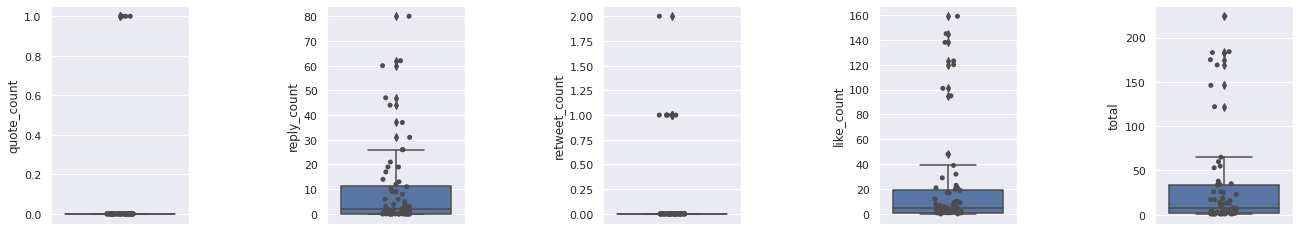

In [5]:
fig, ax = plt.subplots(ncols=len(df.columns))
plt.subplots_adjust(right=3, wspace=1)
for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax = ax[i])
    sns.stripplot(y=df[col], color=".3", ax=ax[i])

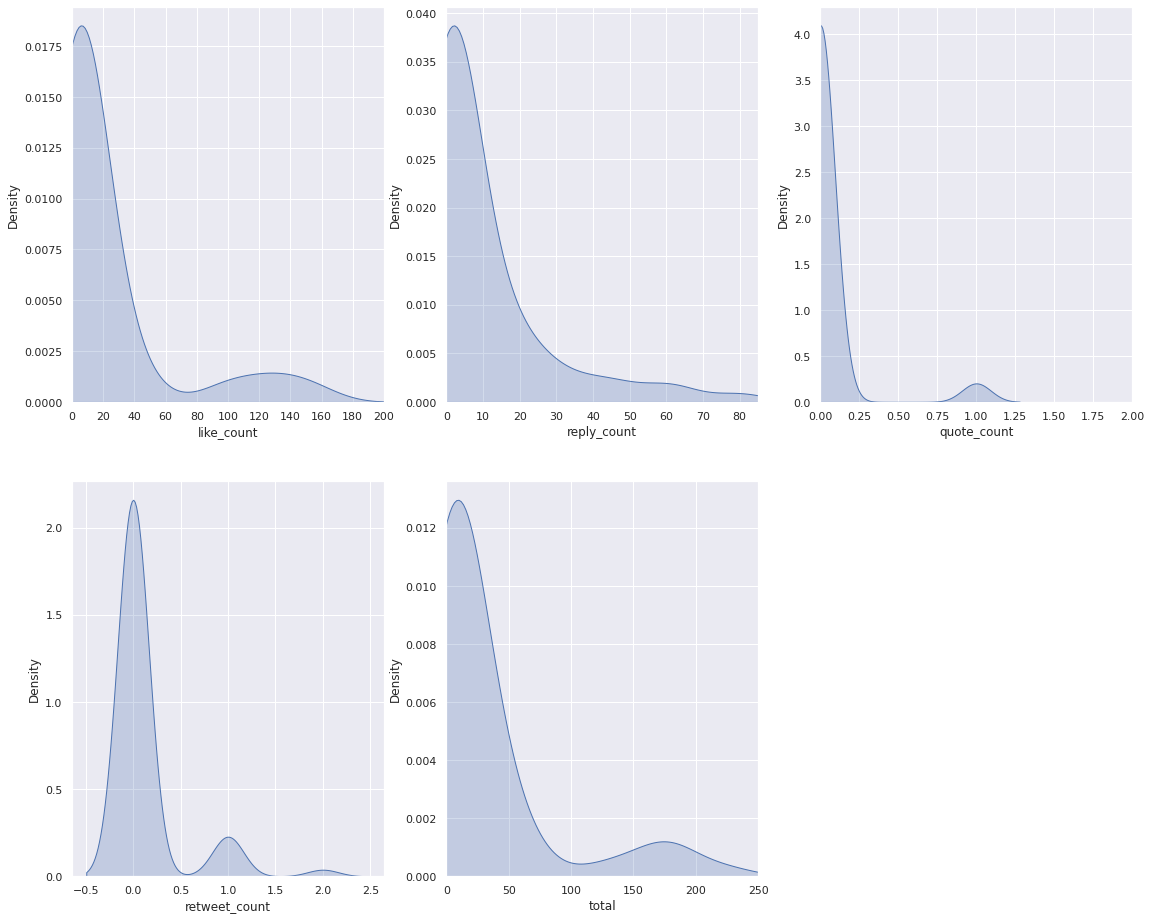

In [6]:
from matplotlib.ticker import MaxNLocator
fig, axs = plt.subplots(2, 3, figsize=(19,16))
axs[1,2].set_visible(False)

# for likes
ax = axs[0,0]
bins = np.arange(0,160,1)
#sns.histplot(data=df, x="like_count", bins=bins, alpha=0.4, ax=ax, kde=True)
sns.kdeplot(data=df, x="like_count", ax=ax, fill=True)
_ = ax.set_xlim(0,200)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# for replies
ax = axs[0,1]
bins = np.arange(0,85,1)
##sns.histplot(data=df, x="reply_count", bins=bins, stat="probability", alpha=0.4, ax=ax)
sns.kdeplot(data=df, x="reply_count", ax=ax, fill=True)
_ = ax.set_xlim(0,85)

# for quotes
ax = axs[0,2]
bins = np.arange(0,2,0.5)
#sns.histplot(data=df, x="quote_count", bins=bins, stat="probability", alpha=0.4, ax=ax)
sns.kdeplot(data=df, x="quote_count", ax=ax, fill=True)
_ = ax.set_xlim(0,2)

# for retweets
ax = axs[1,0]
bins = np.arange(0,2,0.5)
#sns.histplot(data=df, x="retweet_count", bins=bins, stat="probability", alpha=0.4, ax=ax)
sns.kdeplot(data=df, x="retweet_count", ax=ax, fill=True)

# for total
ax = axs[1,1]
bins = np.arange(0,250,1)
#sns.histplot(data=df, x="total", bins=bins, stat="probability", alpha=0.4, ax=ax)
sns.kdeplot(data=df, x="total", ax=ax, fill=True)
_ = ax.set_xlim(0,250)

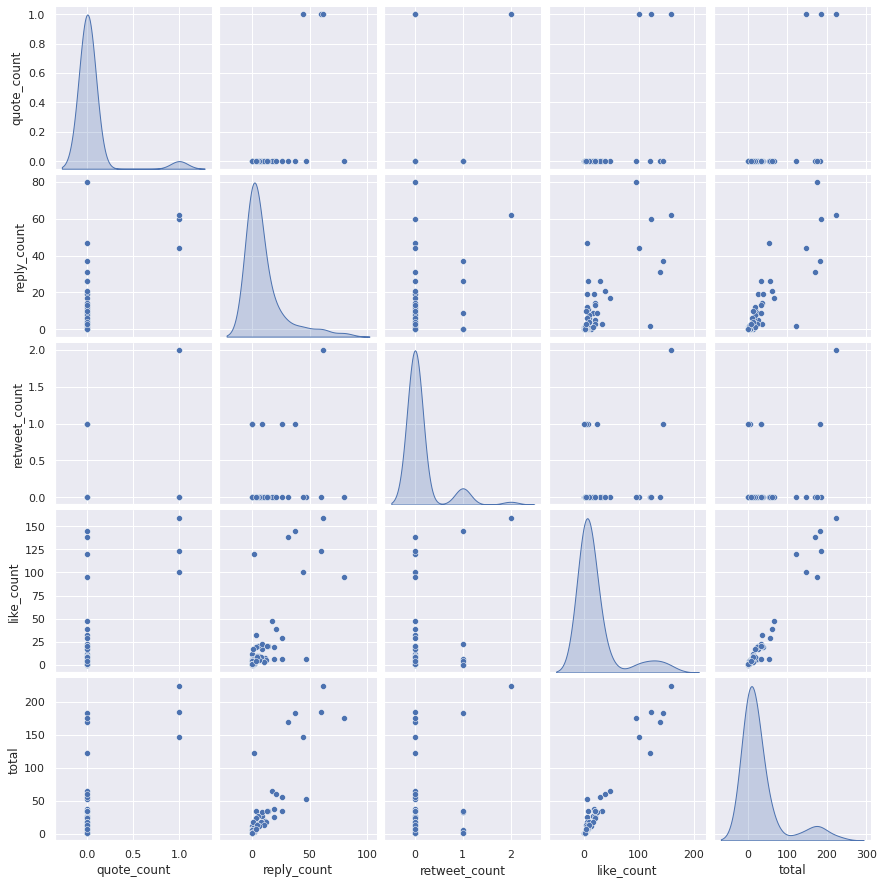

In [8]:
sns.pairplot(df, diag_kind="kde")

TODO:
- Usar pairplto para cambiar el bineado 
   - https://stackoverflow.com/questions/56384137/custom-binning-in-seaborn-pairplot
   - https://stackoverflow.com/questions/59696426/how-to-change-the-number-of-bins-in-seaborns-pairplot-function